# Classification à partir d'un arbre de décision et de forêts aléatoires

On va utiliser le jeu de données Pima Indian Diabetes disponible [là par exemple](https://www.kaggle.com/uciml/pima-indians-diabetes-database). Le dataset est déjà chargé dans l'environnement.

## Import des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import des données

In [2]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Visualisation, analyse exploratoire et gestion des éventuels problèmes sur les données

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


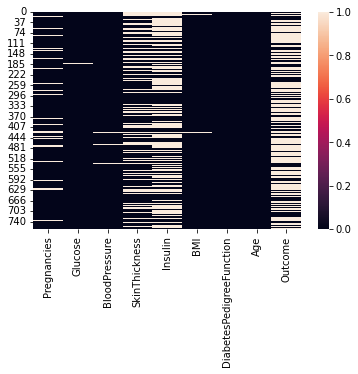

In [5]:
sns.heatmap(data == 0);

Pour BloodPressure, BMI et Glucose, il y a peu de valeurs manquantes (valeurs manquantes = valeurs 0) on peut donc supprimer les lignes concernées.

In [6]:
data = data[(data.BloodPressure != 0) & (data.BMI != 0) & (data.Glucose != 0)]
data.shape

(724, 9)

Pour Insulin et SkinThickness, il y a beaucoup de 0. On va donc essayer de voir l'importance de ces variables avant de prendre un décision.

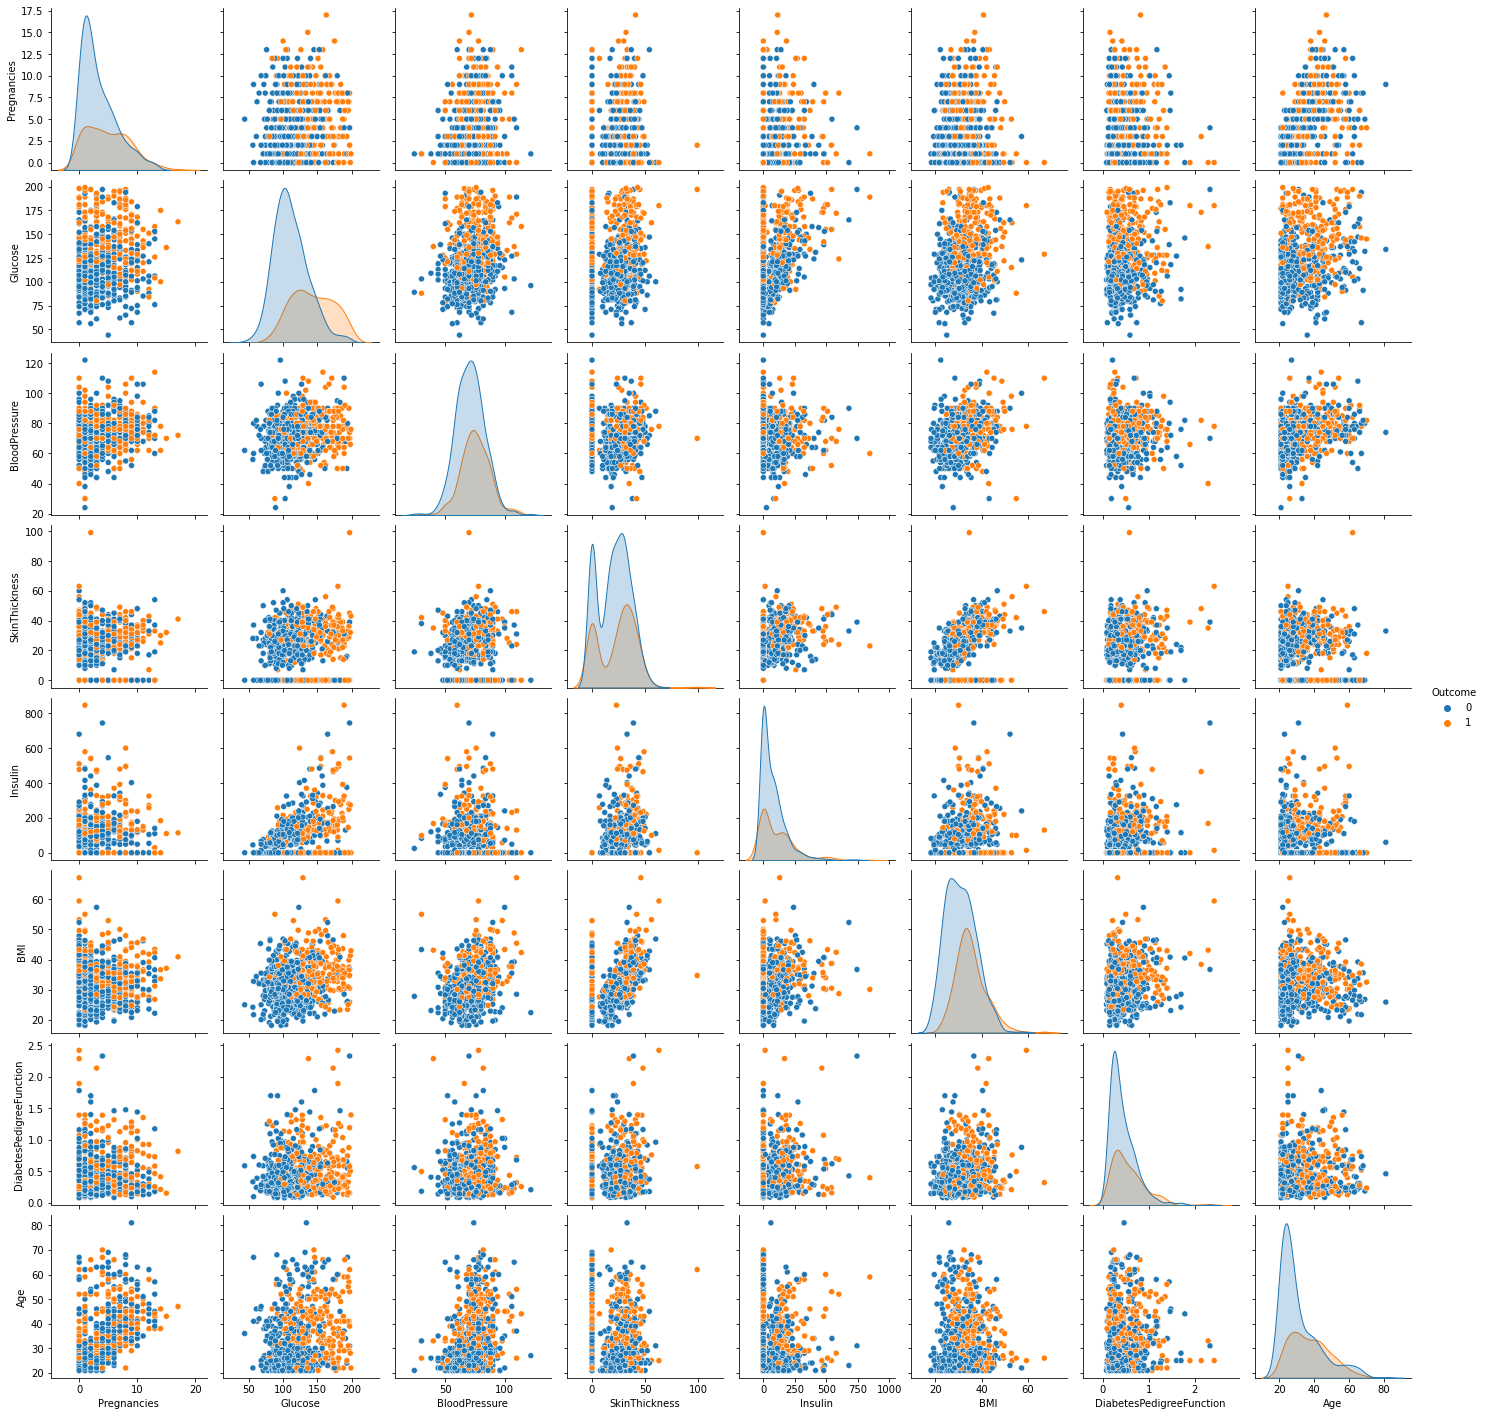

In [7]:
sns.pairplot(data, hue='Outcome');

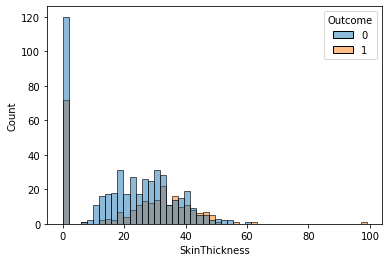

In [8]:
sns.histplot(data=data, x='SkinThickness', hue='Outcome', bins=50);

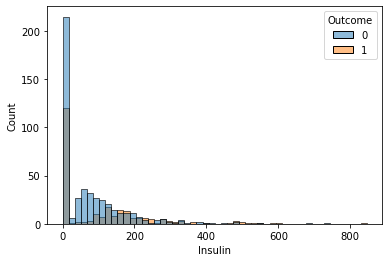

In [9]:
sns.histplot(data=data, x='Insulin', hue='Outcome', bins=50);

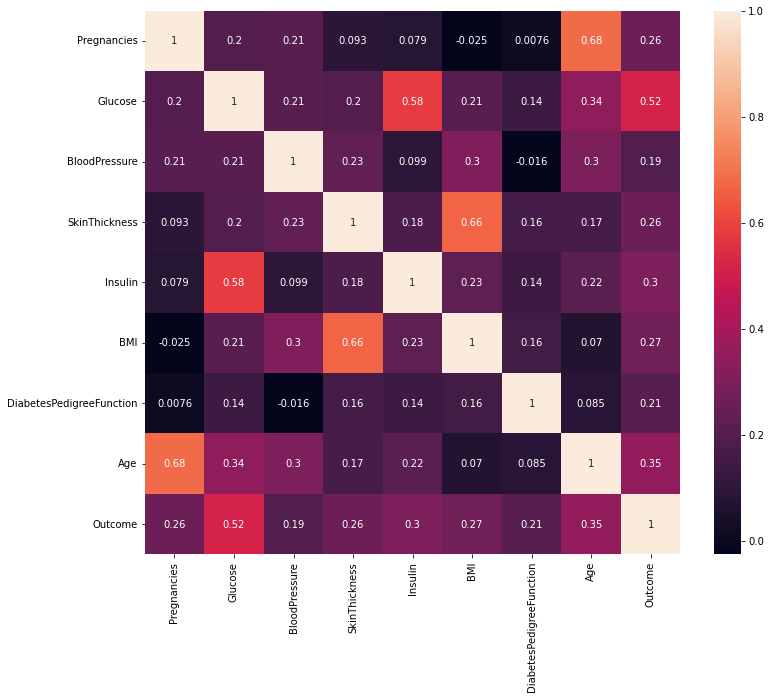

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(data[(data.Insulin != 0) & (data.SkinThickness != 0)].corr(), annot=True);

A priori, les 2 variables ont un impact sur la présence ou non d'un diabète. Il faut donc les garder pour le moment. Deux possibilités :
- soit on impute la moyenn/médiane (zn faisant des groupes ou non) : problème c'est qu'il en manque beaucoup et donc on rend "constante" une variable qui ne l'est pas...
- soit on les vire observations concernées

In [11]:
# en supprimant les lignes concernées
data = data[(data.Insulin != 0) & (data.SkinThickness != 0)]
data.shape

(392, 9)

#### Une autre solution

On peut imputer une valeur obtenue par une régression : on va faire un modèle pour prédire l'insuline à partir des autres variables explicatives et de l'outcome.

In [12]:
# on recharge les données avec les traitements qu'on conserve
data = pd.read_csv("diabetes.csv")
data = data[(data.BloodPressure != 0) & (data.BMI != 0) & (data.Glucose != 0)]

In [13]:
# fonction pour imputer par régression linéaire
from sklearn.linear_model import LinearRegression

def reglin_imput(data, variable):
    X_train_imput = data[(data[variable] != 0)].drop(variable, axis=1)
    y_train_imput = data.loc[(data[variable] != 0), variable]

    X_manquants = data[(data[variable] == 0)].drop(variable, axis=1)

    reglin = LinearRegression().fit(X_train_imput, y_train_imput)
    imputed = reglin.predict(X_manquants)
    data.loc[(data[variable] == 0), variable] = imputed

In [14]:
# régression linéaire pour imputer l'insuline
reglin_imput(data, 'Insulin')

In [15]:
# régression linéaire pour imputer l'épaisseur de la peau
reglin_imput(data, 'SkinThickness')

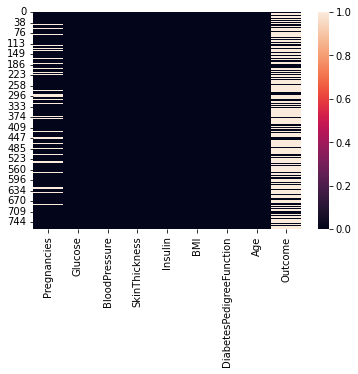

In [16]:
sns.heatmap(data == 0);

```python
# cellule pour implémenter la médiane/moyenne sur toutes les variables ayant des 0, si c'était la solution choisie
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=0, strategy='median')
data[['SkinThickness', 'Insulin']] = imputer.fit_transform(data[['SkinThickness', 'Insulin']])
```

## Préparation des différents datasets pour la modélisation

In [17]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(615, 8) (109, 8) (615,) (109,)


## Un premier arbre de décision

Créer et entrainer un arbre de décision puis calculer l'accuracy et afficher l'arbre obtenu.

In [19]:
from sklearn.tree import DecisionTreeClassifier
arb = DecisionTreeClassifier()
arb.fit(X_train, y_train)
arb.score(X_train, y_train), arb.score(X_test, y_test)

(1.0, 0.6972477064220184)

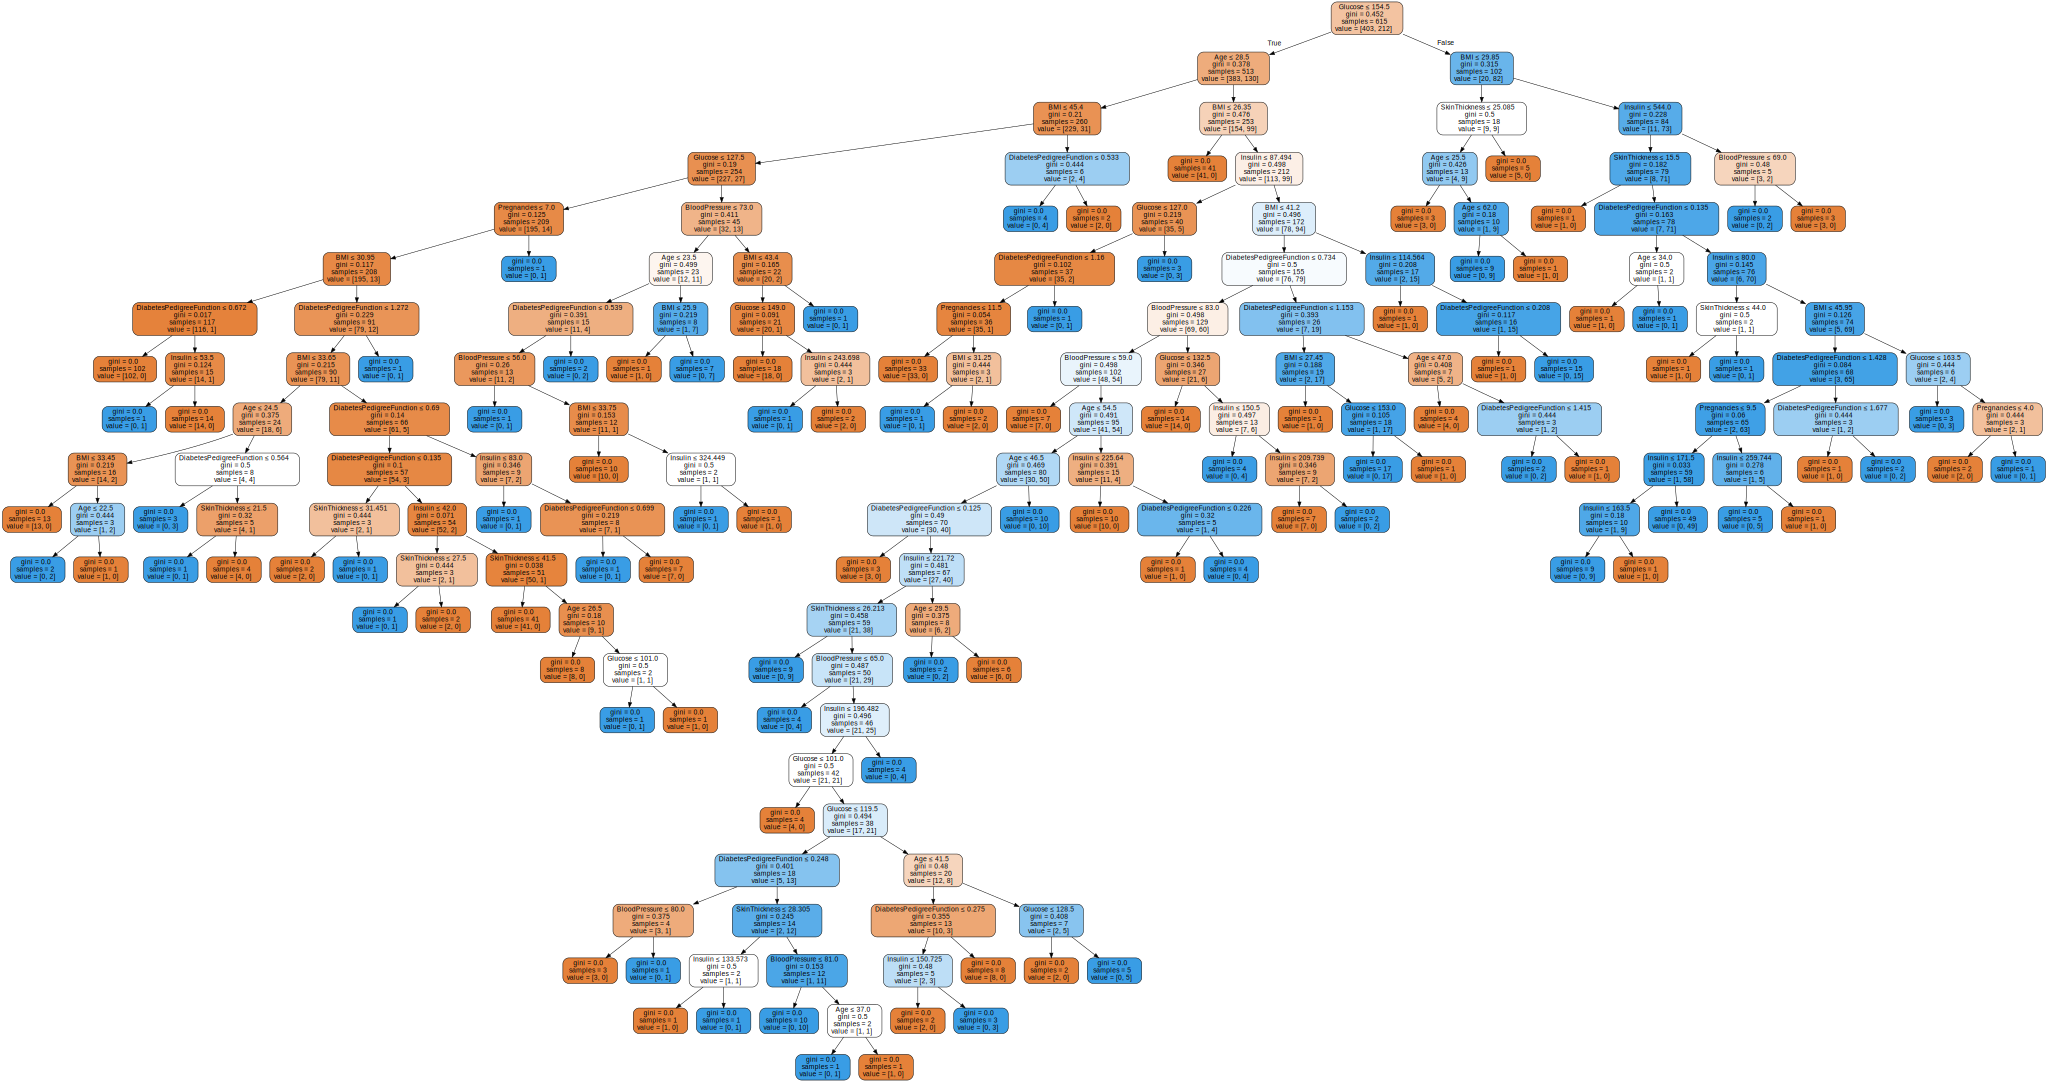

In [20]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(arb, out_file=None,
            feature_names=arb.feature_names_in_,
            filled=True, rounded=True,
            special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

In [21]:
# affichage de l'importance des features
feat_imp = pd.DataFrame(arb.feature_importances_,
                        columns=['Importance des variables'],
                        index=arb.feature_names_in_)
feat_imp.sort_values('Importance des variables', ascending=False)

,Importance des variables
Glucose,0.269521
Age,0.169617
Insulin,0.158896
BMI,0.144008
DiabetesPedigreeFunction,0.124125
BloodPressure,0.069950
SkinThickness,0.049709
Pregnancies,0.014174


## Un second arbre de décision

Refaire la même chose en modifiant les paramètres de la classe `DecisionTreeClassifier`, notamment `max_depth` et `criterion`.

score train : 0.7691056910569106, score test : 0.7522935779816514


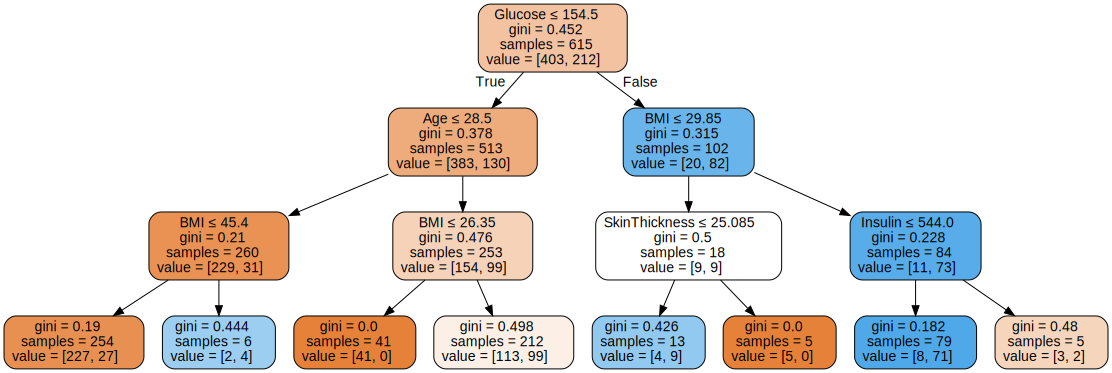

In [23]:
from sklearn.tree import DecisionTreeClassifier
arb = DecisionTreeClassifier(max_depth=3, criterion='gini')
arb.fit(X_train, y_train)
print(f"score train : {arb.score(X_train, y_train)}, score test : {arb.score(X_test, y_test)}")

# visualisation
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(arb, out_file=None,
            feature_names=arb.feature_names_in_,
            filled=True, rounded=True,
            special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

In [24]:
# affichage de l'importance des features
feat_imp = pd.DataFrame(arb.feature_importances_,
                        columns=['Importance des variables'],
                        index=arb.feature_names_in_)
feat_imp.sort_values('Importance des variables', ascending=False)

,Importance des variables
Glucose,0.520610
BMI,0.229189
Age,0.191641
SkinThickness,0.034944
Insulin,0.023615
Pregnancies,0.000000
BloodPressure,0.000000
DiabetesPedigreeFunction,0.000000


## Un peu de validation croisée pour affiner les hyperparamètres

Utiliser la fonction adéquate pour tester différentes valeurs des paramètres(`max_depth` et `criterion`).

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid ={
    'max_depth': list(range(1,11)) + [None],
    'criterion': ['gini', 'entropy']
}

grid_cv = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=60)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=60, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]})

In [26]:
print(f"Meileurs paramètres sur le jeu d'entraînement {grid_cv.best_params_}")

print("Accuracy de chacun des modèles :")
for res, params in zip(grid_cv.cv_results_['params'], grid_cv.cv_results_['mean_test_score']):
    print(f"pour les paramètres {res}, la précision du modèle est {params}")

Meileurs paramètres sur le jeu d'entraînement {'criterion': 'entropy', 'max_depth': 6}
Accuracy de chacun des modèles :
pour les paramètres {'criterion': 'gini', 'max_depth': 1}, la précision du modèle est 0.6950000000000001
pour les paramètres {'criterion': 'gini', 'max_depth': 2}, la précision du modèle est 0.7037878787878787
pour les paramètres {'criterion': 'gini', 'max_depth': 3}, la précision du modèle est 0.7116666666666667
pour les paramètres {'criterion': 'gini', 'max_depth': 4}, la précision du modèle est 0.7440909090909091
pour les paramètres {'criterion': 'gini', 'max_depth': 5}, la précision du modèle est 0.733939393939394
pour les paramètres {'criterion': 'gini', 'max_depth': 6}, la précision du modèle est 0.726969696969697
pour les paramètres {'criterion': 'gini', 'max_depth': 7}, la précision du modèle est 0.7224242424242424
pour les paramètres {'criterion': 'gini', 'max_depth': 8}, la précision du modèle est 0.724848484848485
pour les paramètres {'criterion': 'gini', '

In [27]:
best_tree = grid_cv.best_estimator_
best_tree.score(X_test, y_test)

0.6972477064220184

## Et une petite forêt aléatoire pour finir...

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(f"score train : {rf.score(X_train, y_train)}, score test : {rf.score(X_test, y_test)}")

score train : 1.0, score test : 0.7155963302752294


## ...avec validation croisée pour le nombre d'arbres de la forêt

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid ={
    'n_estimators': [10, 100, 200, 500, 1000] 
}

grid_cv = GridSearchCV(RandomForestClassifier(), param_grid, cv=30)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=30, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [10, 100, 200, 500, 1000]})

In [30]:
print(f"Meileurs paramètres sur le jeu d'entraînement {grid_cv.best_params_}")

print("Accuracy de chacun des modèles :")
for res, params in zip(grid_cv.cv_results_['params'], grid_cv.cv_results_['mean_test_score']):
    print(f"pour les paramètres {res}, la précision du modèle est {params}")

Meileurs paramètres sur le jeu d'entraînement {'n_estimators': 200}
Accuracy de chacun des modèles :
pour les paramètres {'n_estimators': 10}, la précision du modèle est 0.7457142857142858
pour les paramètres {'n_estimators': 100}, la précision du modèle est 0.7573809523809526
pour les paramètres {'n_estimators': 200}, la précision du modèle est 0.7703174603174604
pour les paramètres {'n_estimators': 500}, la précision du modèle est 0.7688095238095237
pour les paramètres {'n_estimators': 1000}, la précision du modèle est 0.7591269841269843


In [31]:
param_grid ={'n_estimators': [100, 150, 200, 250]}

grid_cv = GridSearchCV(RandomForestClassifier(), param_grid, cv=30)
grid_cv.fit(X_train, y_train)

print(f"Meileurs paramètres sur le jeu d'entraînement {grid_cv.best_params_}")

print("Accuracy de chacun des modèles :")
for res, params in zip(grid_cv.cv_results_['params'], grid_cv.cv_results_['mean_test_score']):
    print(f"pour les paramètres {res}, la précision du modèle est {params}")

Meileurs paramètres sur le jeu d'entraînement {'n_estimators': 250}
Accuracy de chacun des modèles :
pour les paramètres {'n_estimators': 100}, la précision du modèle est 0.7494444444444446
pour les paramètres {'n_estimators': 150}, la précision du modèle est 0.7656349206349209
pour les paramètres {'n_estimators': 200}, la précision du modèle est 0.7641269841269843
pour les paramètres {'n_estimators': 250}, la précision du modèle est 0.7671428571428572


In [32]:
# affichage de l'importance des features
best_rf = grid_cv.best_estimator_
feat_imp = pd.DataFrame(best_rf.feature_importances_,
                        columns=['Importance des variables'],
                        index=best_rf.feature_names_in_)
feat_imp.sort_values('Importance des variables', ascending=False)

,Importance des variables
Glucose,0.227479
Insulin,0.149254
BMI,0.135886
Age,0.129250
DiabetesPedigreeFunction,0.109630
SkinThickness,0.101262
Pregnancies,0.075264
BloodPressure,0.071975


## Un petit dernier : Gradient Boosting

Gradient Boosting est une amélioration des forêts aléatoires. Il en existe d'autres, notamment XGBoost pour Extreme Gradient Boosting qui est un mdèle performant dans de nombreux cas. Juste un petit aperçu...

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
print(f"score train : {gb.score(X_train, y_train)}, score test : {gb.score(X_test, y_test)}")

score train : 0.9317073170731708, score test : 0.7339449541284404


In [38]:
param_grid ={
    'n_estimators': [10, 100, 200, 500],
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}

grid_cv = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=20)
grid_cv.fit(X_train, y_train)

print(f"Meileurs paramètres sur le jeu d'entraînement {grid_cv.best_params_}")

print("Accuracy de chacun des modèles :")
for res, params in zip(grid_cv.cv_results_['params'], grid_cv.cv_results_['mean_test_score']):
    print(f"pour {res} : accuracy = {round(params,3)}")

Meileurs paramètres sur le jeu d'entraînement {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Accuracy de chacun des modèles :
pour {'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 10} : accuracy = 0.655
pour {'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 100} : accuracy = 0.748
pour {'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 200} : accuracy = 0.763
pour {'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 500} : accuracy = 0.774
pour {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 10} : accuracy = 0.655
pour {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 100} : accuracy = 0.746
pour {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 200} : accuracy = 0.761
pour {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500} : accuracy = 0.777
pour {'learning_rate': 0.05, 'loss': 'deviance', 'n_estimators': 10} : accuracy = 0.735
pour {'learning_rate': 0.05, 'loss': 'devian

In [39]:
# affichage de l'importance des features
best_gb = grid_cv.best_estimator_
feat_imp = pd.DataFrame(best_gb.feature_importances_,
                        columns=['Importance des variables'],
                        index=best_gb.feature_names_in_)
feat_imp.sort_values('Importance des variables', ascending=False)

,Importance des variables
Glucose,0.332383
BMI,0.169733
Age,0.129919
Insulin,0.116255
DiabetesPedigreeFunction,0.098913
SkinThickness,0.078949
Pregnancies,0.038205
BloodPressure,0.035643


In [40]:
best_gb.score(X_test,y_test)

0.7247706422018348